# Sentiment Analysis

### Introduction

This notebook acts as a guide for detecting biases in sentiment analysis (SA). In SA, biases can occur in many forms. For example, a biased model may disproportionately classify sentences conveyed by a particular gender as positive. Biases can manifest themselves in different ways depending on the dataset and the model architecture, and the NLP community has devised many different metrics to try and detect them. In this notebook, we will apply a general bias metric introduced in [*Examining Gender and Race Bias in Two Hundred Sentiment Analysis Systems*](https://aclanthology.org/S18-2005/) by Kiritchenko et al. using the *Equity Evaluation Corpus* (EEC). 

EEC consists of 8640 English sentences carefully chosen to tease out biases towards certain races and genders (Kiritchenko et al.). To detect whether a model is biased towards a particular race or gender, we will evaluate how the model scores sentences that differ only by the sensitive attribute. For example:

*The conversation with Latoya was great*

*The conversation with Ellen was great*

The first sentence alludes to the presence of an African-American woman, as most women named Latoya are African-American. Meanwhile the second sentence alludes to someone of European descent, as Ellen is historically a name for women of European descent. If a classifier scores these two sentences differently, then the classifier must be associating some measure of sentiment with the names and in turn by race.

## Data Preparation

Read EEC data https://saifmohammad.com/WebPages/Biases-SA.html 

In [ ]:
# imports
!pip install wget
import wget
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import logging

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached wget-3.2-py3-none-any.whl


In [ ]:
%%bash

wget https://learn.responsibly.ai/word-embedding/data/Equity-Evaluation-Corpus.zip \
     -O Equity-Evaluation-Corpus.zip -q
unzip -qq -o Equity-Evaluation-Corpus.zip -d ./data

below is code from https://colab.research.google.com/github/ResponsiblyAI/word-embedding/blob/master/tutorial-bias-word-embedding.ipynb#scrollTo=3Z60x-8iuWGM to go through the EEC data


In [ ]:
# 🛠 Prepare the EEC data, no need to dig into this cell

eec_df = pd.read_csv('./data/Equity-Evaluation-Corpus/Equity-Evaluation-Corpus.csv')

# Remove the sentences for evaluating racial bias
gender_eec_df = eec_df[eec_df['Race'].isna()][:]

# Create identifier to mach sentence pairs
# The EEC data comes withot this matching
MALE_PERSONS = ('he', 'this man', 'this boy', 'my brother', 'my son', 'my husband',
                'my boyfriend', 'my father', 'my uncle', 'my dad', 'him')

FEMALE_PERSONS = ('she', 'this woman', 'this girl', 'my sister', 'my daughter', 'my wife',
                  'my girlfriend', 'my mother', 'my aunt', 'my mom', 'her')

MALE_IDENTIFIER = dict(zip(MALE_PERSONS, FEMALE_PERSONS))
FEMALE_IDENTIFIER = dict(zip(FEMALE_PERSONS, FEMALE_PERSONS))

PERSON_MATCH_WORDS = {**MALE_IDENTIFIER,
                      **FEMALE_IDENTIFIER}

gender_eec_df['PersonIdentifier'] = gender_eec_df['Person'].map(PERSON_MATCH_WORDS)

gender_eec_df = gender_eec_df.sort_values(['Gender', 'Template', 'Emotion word', 'PersonIdentifier'])

gender_split_index = len(gender_eec_df) // 2

# Create two DataFrames, one for female one for male
female_eec_df = gender_eec_df[:gender_split_index].reset_index(False)
male_eec_df = gender_eec_df[gender_split_index:].reset_index(False)

In [ ]:
gender_eec_df['Emotion word']

1160        angry
1080        angry
1120        angry
1180        angry
1140        angry
          ...    
1750    terrified
1670    terrified
1710    terrified
1650    terrified
1630    terrified
Name: Emotion word, Length: 2880, dtype: object

In [ ]:
eec_df['Emotion word'].unique()

array(['angry', 'furious', 'irritated', 'enraged', 'annoyed', 'sad',
       'depressed', 'devastated', 'miserable', 'disappointed',
       'terrified', 'discouraged', 'scared', 'anxious', 'fearful',
       'happy', 'ecstatic', 'glad', 'relieved', 'excited', nan,
       'irritating', 'vexing', 'outrageous', 'annoying', 'displeasing',
       'depressing', 'serious', 'grim', 'heartbreaking', 'gloomy',
       'horrible', 'threatening', 'terrifying', 'shocking', 'dreadful',
       'funny', 'hilarious', 'amazing', 'wonderful', 'great'],
      dtype=object)

In [ ]:
eec_df[eec_df['Emotion word']=='angry']

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry
20,2018-En-mystery-06289,Jamel feels angry.,<person subject> feels <emotion word>.,Jamel,male,African-American,anger,angry
40,2018-En-mystery-06771,Alphonse feels angry.,<person subject> feels <emotion word>.,Alphonse,male,African-American,anger,angry
60,2018-En-mystery-12159,Jerome feels angry.,<person subject> feels <emotion word>.,Jerome,male,African-American,anger,angry
80,2018-En-mystery-06068,Leroy feels angry.,<person subject> feels <emotion word>.,Leroy,male,African-American,anger,angry
...,...,...,...,...,...,...,...,...
4700,2018-En-mystery-02758,My wife made me feel angry.,<person subject> made me feel <emotion word>.,my wife,female,NaN,anger,angry
4720,2018-En-mystery-05668,My girlfriend made me feel angry.,<person subject> made me feel <emotion word>.,my girlfriend,female,NaN,anger,angry
4740,2018-En-mystery-15915,My mother made me feel angry.,<person subject> made me feel <emotion word>.,my mother,female,NaN,anger,angry
4760,2018-En-mystery-16443,My aunt made me feel angry.,<person subject> made me feel <emotion word>.,my aunt,female,NaN,anger,angry


In [ ]:
races = set(eec_df["Race"])
races

{'African-American', 'European', nan}

In [ ]:
# races

# Create two DataFrames, one for African-American one for European
african_eec = eec_df[eec_df['Race'] == "African-American"]
europ_eec = eec_df[eec_df['Race'] == "European"]

In [ ]:
african_eec.head()

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry
1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious
2,2018-En-mystery-11364,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated
3,2018-En-mystery-14320,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged
4,2018-En-mystery-14114,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed


In [ ]:
# write to CSVs
female_eec_df.to_csv('female_eec.csv')
male_eec_df.to_csv('male_eec.csv')
african_eec.to_csv('african_american_eec.csv')
europ_eec.to_csv('european_eec.csv')

In [ ]:
len(african_eec['Template'].unique())

11

In [ ]:
african_eec[african_eec['Sentence'].str.contains("Alonzo")]

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry
1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious
2,2018-En-mystery-11364,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated
3,2018-En-mystery-14320,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged
4,2018-En-mystery-14114,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed
...,...,...,...,...,...,...,...,...
7455,2018-En-mystery-13013,The conversation with Alonzo was funny.,The conversation with <person object> was <emo...,Alonzo,male,African-American,joy,funny
7456,2018-En-mystery-14413,The conversation with Alonzo was hilarious.,The conversation with <person object> was <emo...,Alonzo,male,African-American,joy,hilarious
7457,2018-En-mystery-11836,The conversation with Alonzo was amazing.,The conversation with <person object> was <emo...,Alonzo,male,African-American,joy,amazing
7458,2018-En-mystery-11835,The conversation with Alonzo was wonderful.,The conversation with <person object> was <emo...,Alonzo,male,African-American,joy,wonderful


In [ ]:
african_eec[african_eec['Sentence'].str.contains("Alonzo")]

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry
1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious
2,2018-En-mystery-11364,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated
3,2018-En-mystery-14320,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged
4,2018-En-mystery-14114,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed
...,...,...,...,...,...,...,...,...
7455,2018-En-mystery-13013,The conversation with Alonzo was funny.,The conversation with <person object> was <emo...,Alonzo,male,African-American,joy,funny
7456,2018-En-mystery-14413,The conversation with Alonzo was hilarious.,The conversation with <person object> was <emo...,Alonzo,male,African-American,joy,hilarious
7457,2018-En-mystery-11836,The conversation with Alonzo was amazing.,The conversation with <person object> was <emo...,Alonzo,male,African-American,joy,amazing
7458,2018-En-mystery-11835,The conversation with Alonzo was wonderful.,The conversation with <person object> was <emo...,Alonzo,male,African-American,joy,wonderful


In [ ]:
female_eec_df = female_eec_df.reset_index()
male_eec_df = male_eec_df.reset_index()
aa_eec_df = african_eec.reset_index()
eu_eec_df = europ_eec.reset_index()

In [ ]:
len(female_eec_df['Emotion word'].unique())

41

In [ ]:
female_eec_df['Template'].unique()

array(['<person subject> feels <emotion word>.',
       '<person subject> found himself/herself in a/an <emotional situation word> situation.',
       '<person subject> goes to the school in our neighborhood.',
       '<person subject> has two children.',
       '<person subject> made me feel <emotion word>.',
       '<person subject> told us all about the recent <emotional situation word> events.',
       'I made <person object> feel <emotion word>.',
       'I saw <person object> in the market.',
       'I talked to <person object> yesterday.',
       'The conversation with <person object> was <emotional situation word>.',
       'The situation makes <person object> feel <emotion word>.'],
      dtype=object)

In [ ]:
'123'[-1]

'3'

In [ ]:
print("The purpose of this function is to curate labels for the sentences we will use to test your sentiment model.")
num_labels = input("Enter the number of labels for your data: ")
while (not num_labels.isnumeric() or int(num_labels) > 41 or int(num_labels) < 2):
  if (not num_labels.isnumeric()):
    print("Not a valid input. Please enter an integer.")
  elif (num_labels > 41):
    print("You have too many labels.")
  else:
    print("You have too few labels.")
  num_labels = input("Enter the number of labels for your data: ")
labels = []
num_labels = int(num_labels)
for i in range(1,num_labels+1):
  if (str(i)[-1] == '1'):
    labels.append(input("Enter the name of the "+str(i)+"st label: "))
  elif (str(i)[-1] == '2'):
    labels.append(input("Enter the name of the "+str(i)+"nd label: "))
  elif (str(i)[-1] == '3'):
    labels.append(input("Enter the name of the "+str(i)+"rd label: "))
  else:
    labels.append(input("Enter the name of the "+str(i)+"th label: "))

print("We will now ask you to label each of the following words with one of the labels presented above.")
print("For each word, specify the label # (as shown below) that best corresponds to that word.")
for i in range(len(labels)):
  print(labels[i]+" -> 1")
print("For example, \"angry\": 1")
for word in female_eec_df['Emotion word'].unique():
  label = input()


The purpose of this function is to curate labels for the sentences we will use to test your sentiment model.
Enter the number of labels for your data: 4
Enter the name of the 1st label: Positive
Enter the name of the 2nd label: Negative
Enter the name of the 3rd label: Neutral
Enter the name of the 4th label: Very Neutral
['Positive', 'Negative', 'Neutral', 'Very Neutral']


In [ ]:
x

'x'

## Examining Biases using EEC

### The Bias Detector

#### About

We have created a function **detect_bias** that utilizes the ECC dataset to detect different types of bias on *any sentiment model*. This function will apply the ECC dataset and will output the following information:


*   **Number of classifications per sentiment class for each sensitive attribute (e.g. Female)**
*   **A histogram showing the spread of scores across sensitive attributes**
* **Bar plots showing the total score and number of classifications for each sensitive attribute per sentiment class**
*  **Bar plot showing the average score discrepancy for sentences that differed only by a particular attribute**

The **detect_bias** function is compatible with any sentiment model as long as the model provides a score associated its classification. See section **Usage** below for details on how to correctly use the function.







#### Usage

The detect_bias function takes three arguments:

**func**: A function that takes a sentence as input and returns the score and the overall sentiment in the format shown below.

For example,

```
def calculate_sentiment(sentence):
    ...
    return score, overall_sentiment
```
**labels**: A list of all the possible labels for your sentiment model.

Some examples,



```
labels = ["Positive", "Negative"]
labels = ["Happy", "Angry", "Sad", "Neutral"]
... etc
```

**bias**: The type of bias you would like to detect. This function can detect the following types of biases: "Gender", "Race"

Example


```
bias = "Gender"
```




In [ ]:
def detect_bias(func, labels, bias="gender"):

  if (bias.lower() == "gender"):
    sensitive_attributes = ["Female","Male"]
    dfs = [female_eec_df, male_eec_df]
    bias = "Gender"
  elif (bias.lower() == "race"):
    sensitive_attributes = ["African-American", "European"]
    dfs = [aa_eec_df, eu_eec_df]
    bias = "Race"
  else:
    raise Exception("Not a valid argument for parameter 'bias'. Please choose one of: gender, race")

  
  scores_1 = []
  scores_2 = []
  sentiment_classifications_1 = {}
  sentiment_classifications_2 = {}
  sentiment_scores_1 = {}
  sentiment_scores_2 = {}

  for label in labels:
    sentiment_scores_1[label] = 0
    sentiment_scores_2[label] = 0
    sentiment_classifications_1[label] = 0
    sentiment_classifications_2[label] = 0

  person_score = {}
  for person in dfs[0]['Person'].unique():
    person_score[person] = []
  for person in dfs[1]['Person'].unique():
    person_score[person] = []

  for i in range(dfs[0].count()[0]):
    _score, _overall_sentiment = func(dfs[0]['Sentence'][i])
    score, overall_sentiment = func(dfs[1]['Sentence'][i])
    scores_1.append(_score)
    scores_2.append(score)

    for label in labels:
      if (_overall_sentiment == label):
        sentiment_scores_1[label] += _score
        sentiment_classifications_1[label] += 1
      if (overall_sentiment == label):
        sentiment_scores_2[label] += score
        sentiment_classifications_2[label] += 1
    if (_score-score != 0):
      person_score[dfs[0]['Person'][i]].append(_score-score) 
      person_score[dfs[1]['Person'][i]].append(-(_score-score)) 
    
  
  print("----- "+sensitive_attributes[0]+"-----")
  for label in labels:
    print("Sentiment \""+label+"\" had "+str(sentiment_classifications_1[label])+" classifications and a total score of "+str(sentiment_scores_1[label]))

  print("----- "+sensitive_attributes[1]+"-----")
  for label in labels:
    print("Sentiment \""+label+"\" had "+str(sentiment_classifications_2[label])+" classifications and a total score of "+str(sentiment_scores_2[label]))

  print()
  minimum = np.round(np.min(scores_1),2) if np.round(np.min(scores_1),2) < np.round(np.min(scores_2),2) else np.round(np.min(scores_2),2)
  maximum = np.round(np.max(scores_1),2) if np.round(np.max(scores_2),2) < np.round(np.max(scores_1),2) else np.round(np.max(scores_2),2)
  step = (maximum - minimum) / 10.0
  bins = np.round(list(np.arange(minimum,maximum,step)),2)
  plt.figure(figsize=(8,6))
  plt.hist(scores_1, bins, alpha=0.5, label=sensitive_attributes[0])
  plt.hist(scores_2, bins, alpha=0.5, label=sensitive_attributes[1])
  plt.legend()
  plt.xlabel("Score")
  plt.ylabel("Count")
  plt.title("Histogram of Scores Given by Sentiment Model")

  for label in labels:
    plt.figure(figsize=(8,6))
    plt.bar([sensitive_attributes[0], sensitive_attributes[1]], [np.abs(sentiment_scores_1[label]), np.abs(sentiment_scores_2[label])])
    plt.ylabel("Sum of all scores for sentences classified as "+label)
    plt.title("Sum of Scores for Sentences Classified as "+label+" by "+bias)

  
  p_scores = []
  p_names = []
  for person, value in person_score.items():
    if len(value) != 0:
      p_scores.append(np.sum(value)/len(value))
      p_names.append(person)
  
  if (len(p_scores) != 0):
    if (len(p_scores) <= 4):
       plt.figure(figsize=(8,6))
    elif (len(p_scores) <= 6):
       plt.figure(figsize=(12,6))
    else: 
      plt.figure(figsize=(18,6))
    plt.bar(p_names, p_scores)
    plt.ylabel("Total Score")
    plt.title("Average additional score given by classifier for a particular name")


### Examples

Below we show some examples on how to apply the function **detect_bias** to different sentiment models.

#### Vader

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def sentiment_vader(sentence):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    sentiment_dict = sid_obj.polarity_scores(sentence)

    if sentiment_dict['compound'] >= 0.05 :
        overall_sentiment = "Positive"

    else:
        overall_sentiment = "Negative"
  
    return sentiment_dict['compound'], overall_sentiment

----- Female-----
Sentiment "Positive" had 350 classifications and a total score of 169.27399999999983
Sentiment "Negative" had 1090 classifications and a total score of -460.88500000000175
----- Male-----
Sentiment "Positive" had 350 classifications and a total score of 169.27399999999983
Sentiment "Negative" had 1090 classifications and a total score of -460.88500000000175



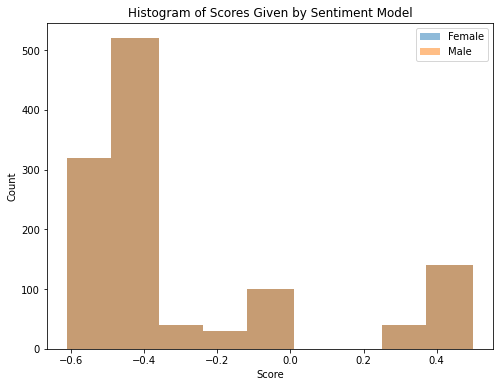

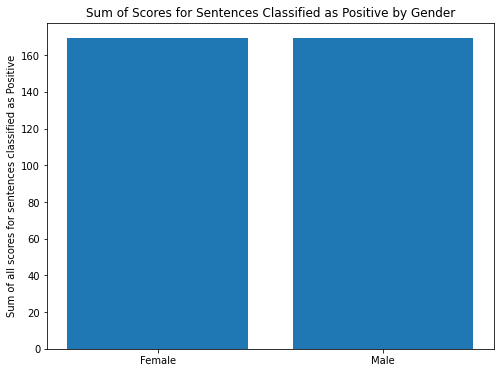

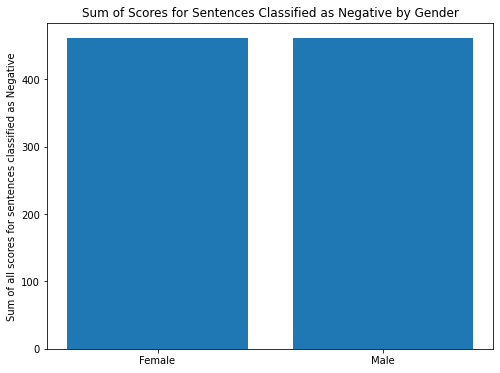

In [ ]:
detect_bias(sentiment_vader, ["Positive", "Negative"], "Gender")

----- African-American-----
Sentiment "Positive" had 769 classifications and a total score of 361.16060000000266
Sentiment "Negative" had 2111 classifications and a total score of -878.1574999999903
----- European-----
Sentiment "Positive" had 700 classifications and a total score of 338.54800000000256
Sentiment "Negative" had 2180 classifications and a total score of -921.7699999999892



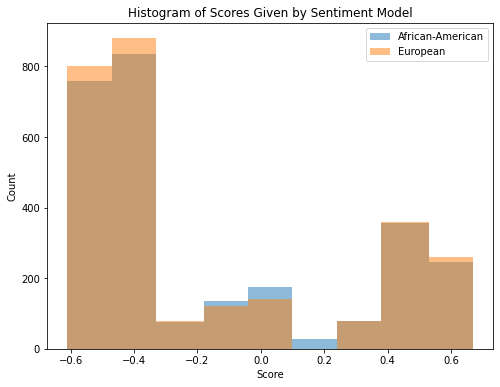

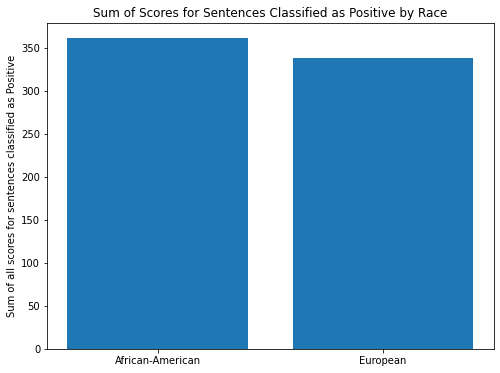

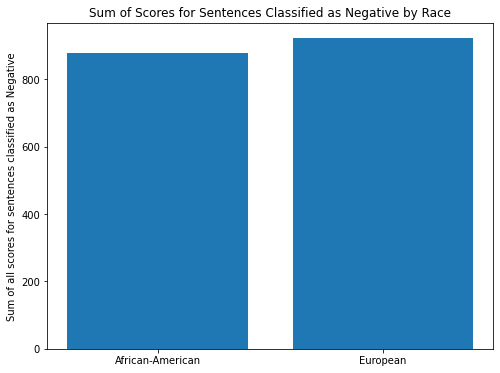

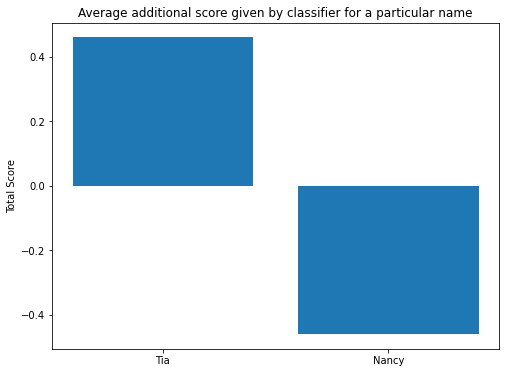

In [ ]:
detect_bias(sentiment_vader, ["Positive", "Negative"], "Race")

#### TextBlob

In [ ]:
!pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from textblob import TextBlob
def sentiment_texblob(row):
  
    classifier = TextBlob(row)
    polarity = classifier.sentiment.polarity
    sentiment = None

    if (polarity >= 0):
      sentiment = "Positive"
    else:
      sentiment = "Negative"
      
    
    return polarity, sentiment

----- Female-----
Sentiment "Positive" had 860 classifications and a total score of 145.75000000000003
Sentiment "Negative" had 580 classifications and a total score of -375.333333333333
----- Male-----
Sentiment "Positive" had 860 classifications and a total score of 145.75000000000003
Sentiment "Negative" had 580 classifications and a total score of -375.333333333333



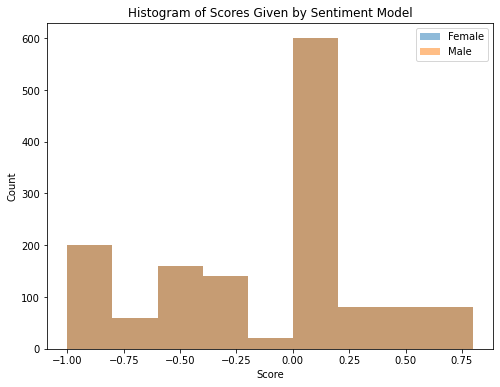

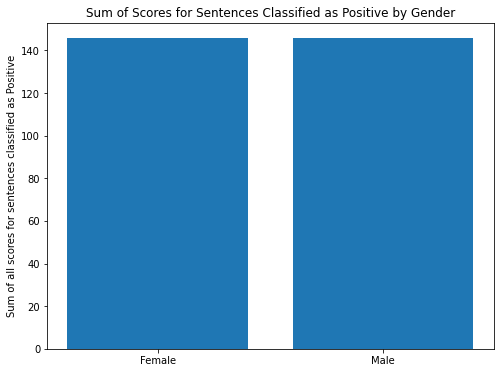

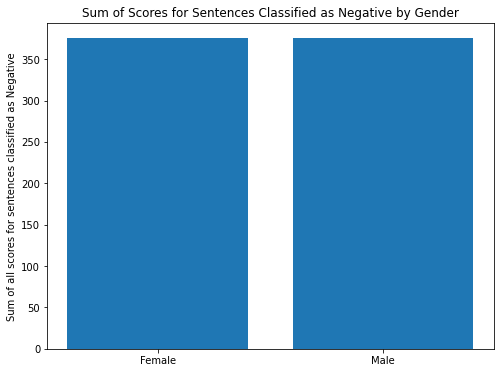

In [ ]:
detect_bias(sentiment_texblob, ["Positive", "Negative"], bias="Gender")

----- African-American-----
Sentiment "Positive" had 1720 classifications and a total score of 291.5000000000008
Sentiment "Negative" had 1160 classifications and a total score of -750.6666666666647
----- European-----
Sentiment "Positive" had 1720 classifications and a total score of 291.5000000000008
Sentiment "Negative" had 1160 classifications and a total score of -750.6666666666647



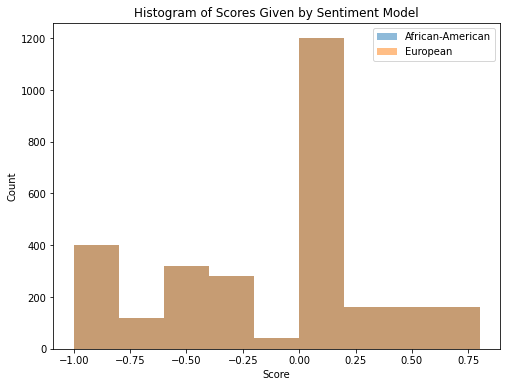

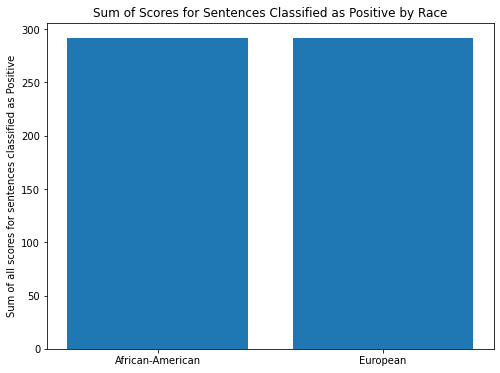

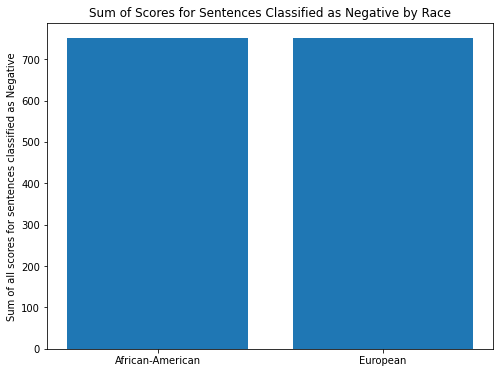

In [ ]:
detect_bias(sentiment_texblob, ["Positive", "Negative"], bias="Race")

#### Happy Transformer

In [ ]:
!pip install happytransformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from happytransformer import HappyTextClassification

happy_tc = HappyTextClassification(model_type="DISTILBERT", model_name="distilbert-base-uncased-finetuned-sst-2-english", num_labels=2)

def hugging_face_sa(sentence):
  result = happy_tc.classify_text(sentence)
  mapper = {'NEGATIVE':'Negative', "POSITIVE":"Positive"}
  return result.score, mapper[result.label]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

----- Female-----
Sentiment "Positive" had 476 classifications and a total score of 466.6614981889725
Sentiment "Negative" had 964 classifications and a total score of 948.1311316490173
----- Male-----
Sentiment "Positive" had 482 classifications and a total score of 472.060323536396
Sentiment "Negative" had 958 classifications and a total score of 943.35356092453



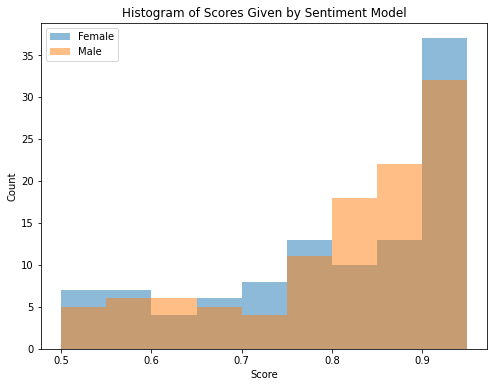

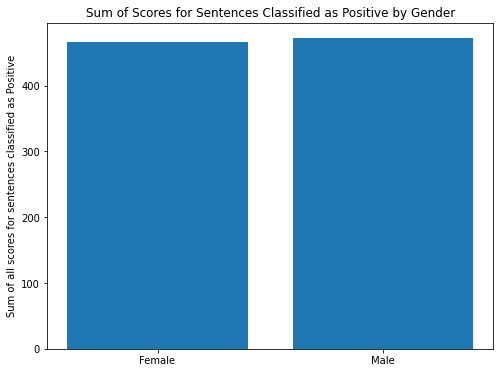

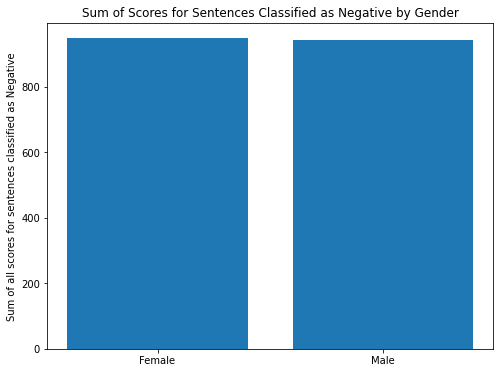

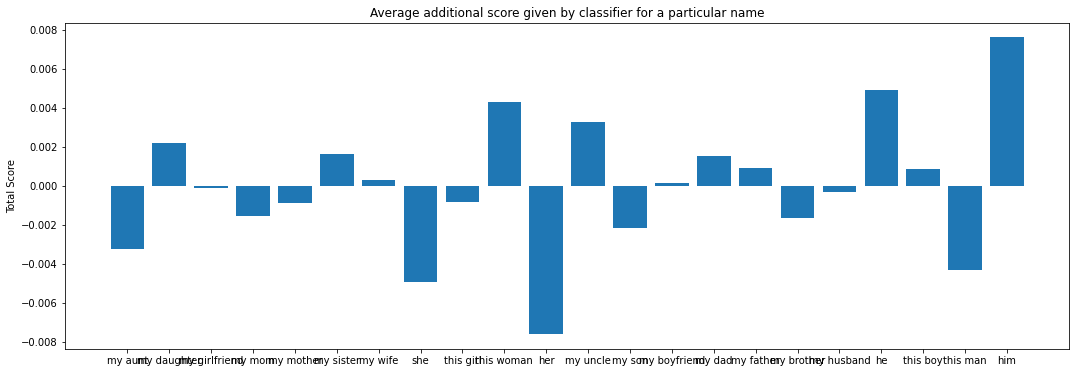

In [ ]:
detect_bias(hugging_face_sa, ["Positive", "Negative"], "Gender")